In [1]:
import csv
import gzip
import io
import sys
from collections import Counter, OrderedDict
import itertools
from itertools import islice, count, groupby
import pandas as pd
import os
import re
from operator import itemgetter
import nltk
from nltk.stem.porter import *
from nltk.corpus import stopwords
from time import time
from timeit import timeit
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
from google.cloud import storage
import math

import hashlib
def _hash(s):
    return hashlib.blake2b(bytes(s, encoding='utf8'), digest_size=5).hexdigest()

nltk.download('stopwords')

from inverted_index_gcp import *

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Install a particular version of `google-cloud-storage` because (oddly enough)
# the  version on Colab and GCP is old. A dependency error below is okay.
!pip install -q google-cloud-storage==1.43.0

In [ ]:
# This is if i want to add spell checking....
!pip install pyspellchecker
from spellchecker import SpellChecker

In [3]:
# authenticate below for Google Storage access as needed
from google.colab import auth
auth.authenticate_user()

In [20]:
import threading

In [29]:
class ThreadSafeCounter(Counter):
    def __init__(self):
        super().__init__()
        self.lock = threading.Lock()

    def __setitem__(self, key, value):
        with self.lock:
            super().__setitem__(key, value)


In [35]:
class BackEnd():
  """
  Class that handle all of the backEnd of the project.
  """
  def __init__(self):

    # Number of docs in the corpus
    self.N = 6348910

    # For inverted index of the text alone:
    self.bucket_name_text = "bucket_ir_102"
    self.base_dir_inverted = "postings_gcp"
    self.text_InvertedIndex = InvertedIndex.read_index(self.base_dir_inverted, "index", self.bucket_name_text)

    # For inverted index of the title alone:
    self.bucket_name_title = "bucket_ir_101"
    self.title_InvertedIndex = InvertedIndex.read_index(self.base_dir_inverted, "index_title", self.bucket_name_title)

    # For Page rank dict:
    bucket_name_for_page_rank = "bucket_ir_100"
    file_name_for_page_rank = "pr/part-00000-bba051bd-4ed5-42d2-ac51-b81e7da0af95-c000.csv.gz"
    self.page_rank_dict = self.read_csv_gzip_to_dict(bucket_name_for_page_rank, file_name_for_page_rank)

    # For title_id:
    bucket_name_for_title_id = "bucket_ir_100"
    file_name_for_title_id = "id_title/part-00000-037780c9-c08d-4f8b-92db-c059071f2db8-c000.csv.gz"
    self.title_id = self.read_csv_gzip_to_dict_with_string(bucket_name_for_title_id, file_name_for_title_id)

    # For doc_legnth dict:
    bucket_name_for_doc_len = "bucket_ir_100"
    file_name_for_doc_len = "word_counts/part-00000-1487dca0-a7d2-4dd0-b547-440beeb5f720-c000.csv.gz"
    self.doc_length_dict = self.read_csv_gzip_to_dict(bucket_name_for_doc_len, file_name_for_doc_len)


    # For stemming
    english_stopwords = frozenset(stopwords.words('english'))
    corpus_stopwords = ["category", "references", "also", "external", "links",
                    "may", "first", "see", "history", "people", "one", "two",
                    "part", "thumb", "including", "second", "following",
                    "many", "however", "would", "became"]

    self.all_stopwords = english_stopwords.union(corpus_stopwords)
    self.RE_WORD = re.compile(r"\b\w{2,24}\b", re.UNICODE)


  def read_csv_gzip_to_dict(self, bucket_name, file_name):
    """
    Reads csv from the bucket, given the file name into a dict and returns it.
    key = doc_id
    value = page rank
    """
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(file_name)

    # Download the file as bytes
    content = blob.download_as_string()

    # Decompress the gzip file and read it as a CSV
    with gzip.open(io.BytesIO(content), "rt") as gzip_file:
        csv_reader = csv.reader(gzip_file)
        header = next(csv_reader)  # Assuming the first row is the header
        data = {int(row[0]): float(row[1]) for row in csv_reader}

    return data

  def read_csv_gzip_to_dict_with_string(self, bucket_name, file_name):
    """
    Reads csv from the bucket, given the file name into a dict and returns it.
    key = doc_id
    value = title
    """
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(file_name)

    # Download the file as bytes
    content = blob.download_as_string()

    # Decompress the gzip file and read it as a CSV
    with gzip.open(io.BytesIO(content), "rt") as gzip_file:
        csv_reader = csv.reader(gzip_file)
        header = next(csv_reader)  # Assuming the first row is the header
        data = {}
        for row in csv_reader:
            try:
                doc_id = int(row[1])
            except ValueError:
                # Skip rows where doc_id is not a valid integer
                continue
            data[doc_id] = row[0]

    return data


  def tf_idf(self, query, tf_idf_dict):
    """
    args:
    query - stemmed and trimmed list of the words that were searched.
    tf_idf_dict- counter

    returns a counter:
      key = doc_id
      value = W (int) calculated by the tf-idf
      with the words asked.
    """

    for word in query:
        # Only handle words that are in the dictionary.
        if word in self.text_InvertedIndex.df:
            term_df = self.text_InvertedIndex.df[word]
            pl = self.text_InvertedIndex.read_a_posting_list(self.base_dir_inverted, word, self.bucket_name_text)
            # Map it to get -> [(doc_id,W)....]
            pl_map = map(lambda x: (x[0],
                        (x[1]/self.doc_length_dict.get(x[0],1))*(math.log2(self.N/term_df))), pl)

            # Update tf_idf_dict with the new values, summing if the key already exists
            tf_idf_dict.update(dict(pl_map))

    return tf_idf_dict



  def page_rank_refactoring(self, tf_idf_dict, factor_value_pr=1):
    """
    After the tf-idf has been done, it will refactor the result
    with Page rank.
    """
    for k in tf_idf_dict.keys():
      tf_idf_dict[k] = factor_value_pr * self.page_rank_dict.get(k, 0)



  def title_refactoring(self, query, tf_idf_dict, factor_value_title=1):
    """
    After the tf-idf has been done, it will refactor the result
    with title factoring, assuming if the words were in the title it
    should have more weight.
    """
    for word in query:
    # Only handle words that are in the dictionary.
      if word in self.title_InvertedIndex.df:
        term_df = self.title_InvertedIndex.df[word]
        pl = self.title_InvertedIndex.read_a_posting_list(self.base_dir_inverted, word, self.bucket_name_title)
        # Map it to get -> [(doc_id,W)....]
        pl_map = map(lambda x: (x[0],factor_value_title * max((math.log2(1+(self.N/term_df))),1)),pl)
        # Update tf_idf_dict with the new values, summing if the key already exists
        tf_idf_dict.update(dict(pl_map))



  def filter_query(self, query):
    """
    This will recive a raw string of the query and stemm it,
    remove stopping words and creating a list of each token in it.
    returning the list.
    """
    stemmer = PorterStemmer()
    tokens = re.findall(self.RE_WORD, query.lower())
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    filtered_tokens = [token for token in stemmed_tokens if token not in self.all_stopwords]
    return filtered_tokens

  def filter_query_title(self, query):
    stop_words = set(stopwords.words('english'))
    word_tokens = re.findall(self.RE_WORD, query.lower())
    filtered_query = [word for word in word_tokens if word.lower() not in self.all_stopwords]
    return filtered_query


  # def correct_typos(self, text):
  #   """
  #   Corrects typos for text.
  #   """
  #   spell = SpellChecker()
  #   words = text.split()
  #   corrected_words = [spell.correction(word) for word in words]
  #   return ' '.join(corrected_words)


  def question_wiki(self, query, use_title=True,use_page_rank=True,TITLE_VALUE_FACTORING=1,PAGE_RANK_FACTORING=1,use_multy_thread=True):
    """
    Going through the entire process, given a string of the question asked,
    it will return the 100 most fitted wiki_id_pages and its title.
    """

    # # Step 1: correct typos.
    # query = self.correct_typos(query)
    original_q = self.filter_query_title(query)

    # Step 2: filter and stem
    query = self.filter_query(query)

    # Step 3: tf_idf on the body
    # Now its multy threaded.
    threads = []
    tf_idf_dict = ThreadSafeCounter()

    if use_multy_thread:
      for q in query:
          thread = threading.Thread(target=self.tf_idf, args=([q], tf_idf_dict))
          threads.append(thread)
          thread.start()

    # Step 3: tf_idf on the body not multy threaded
    else:
      self.tf_idf(query,tf_idf_dict)



    # Step 4: use the title factoring
    if use_title and not use_multy_thread:
      self.title_refactoring(original_q, tf_idf_dict, TITLE_VALUE_FACTORING)

    # Use the title factoring not multy threaded
    if use_title and use_multy_thread:
      for q in original_q:
          thread = threading.Thread(target=self.title_refactoring, args=([q], tf_idf_dict,TITLE_VALUE_FACTORING))
          threads.append(thread)
          thread.start()

    # Make sure to join all of the threads before the pagerank.
    if use_multy_thread:
      for thread in threads:
        thread.join()

    # Step 5: use the page rank refactoring
    if use_page_rank:
      self.page_rank_refactoring(tf_idf_dict, PAGE_RANK_FACTORING)

    # Step 6: Return top 100 results.

    # Convert the Counter to a list of tuples and sort it by value in descending order
    sorted_counter = sorted(tf_idf_dict.items(), key=lambda x: x[1], reverse=True)
    # Get the top 100 items
    top_100_keys = [(doc_id,self.title_id[doc_id],value) for doc_id, value in sorted_counter[:100]]

    return top_100_keys



  def get_posting_list_body(self, word):
    """
    return the posting list of a word by the text index
    """
    return self.text_InvertedIndex.read_a_posting_list(self.base_dir_inverted, word, self.bucket_name_text)

  def get_posting_list_title(self, word):
    """
    return the posting list of a word by the title index
    """
    return self.title_InvertedIndex.read_a_posting_list(self.base_dir_inverted, word, self.bucket_name_title)

  def get_page_rank(self, doc_id):
    """
    returns the page rank by the doc id.
    """
    return self.page_rank_dict.get(doc_id, 0)

  def get_doc_length(self, doc_id):
    # Returns the doc_length by the doc id.
    return self.doc_length_dict.get(doc_id,1)


Testing for indexing

In [36]:
# Create the backEnd
import time
start_time = time.time()
be = BackEnd()
elapsed_time = time.time() - start_time

assert elapsed_time < 100
# Note, shouldnt take more than 100 secs

In [ ]:
con = Counter()
test = be.title_refactoring(["computer"],con)
print(list(con.items())[:10])

test = be.title_refactoring(["computer"],con)

print(list(con.items())[:10])


In [ ]:
# Test for bodyIndexing

# Start the timer
start_time = time.time()

pl = be.get_posting_list_body("computer")


# Calculate and print the elapsed time
elapsed_time = time.time() - start_time
for i in range(10):
  print(pl[i])

print(" ")
print(f"Elapsed time: {elapsed_time} seconds")


In [ ]:
# Test for titleIndexing

# Start the timer
start_time = time.time()

pl = be.get_posting_list_title("computer")

# Calculate and print the elapsed time
elapsed_time = time.time() - start_time
for i in range(30):
  print(pl[i])

print(" ")
print(f"Elapsed time: {elapsed_time} seconds")

In [ ]:
# Test for page rank indexing

doc_id = 2428
# Start the timer
start_time = time.time()

print(be.get_page_rank(doc_id))

print(" ")
# Calculate and print the elapsed time
elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time} seconds")

29.24096506722234
 
Elapsed time: 0.00029969215393066406 seconds


In [ ]:
# Test for doc legth

# Start the timer
start_time = time.time()

print(be.get_doc_length(doc_id))

print(" ")
# Calculate and print the elapsed time
elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time} seconds")

3375.0
 
Elapsed time: 0.0002732276916503906 seconds


In [ ]:
# Test for typos correction

text_with_typos = "ths is an exmple of text with typos"
# Start the timer
start_time = time.time()

corrected_text = be.correct_typos(text_with_typos)


# Calculate and print the elapsed time
elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time} seconds")
print(" ")
assert "the is an example of text with typos" ==  corrected_text

# Took aprox 0.17 secs


In [ ]:
# Test for filter_query

query = "the cat is on the mat"
expected_tokens = ["cat", "mat"]

start_time = time.time()

ans =  be.filter_query(query)

elapsed_time = time.time() - start_time
print(f"Elapsed time: {elapsed_time} seconds")
print(ans)
assert expected_tokens ==  ans


In [ ]:
# Test for tf_idf
start_time = time.time()
ans = be.tf_idf(["computer"])
elapsed_time = time.time() - start_time
print(len(ans))
print(f"Elapsed time: {elapsed_time} seconds")

# assert len(ans) == 134110
assert elapsed_time < 1.5


In [ ]:
# Test for id_title
title = be.title_id[18555]
print(title)

In [ ]:
# Test for question_wiki
start_time = time.time()

ans1 = be.question_wiki("computer violet flower",use_title=True, use_page_rank=True, TITLE_VALUE_FACTORING=1000)

elapsed_time = time.time() - start_time

print(f"Elapsed time With multy thread: {elapsed_time} seconds")

start_time = time.time()

ans2 = be.question_wiki("computer violet flower",use_title=True, use_page_rank=True, TITLE_VALUE_FACTORING=1000,use_multy_thread=False)

elapsed_time = time.time() - start_time

print(f"Elapsed time Without multy thread: {elapsed_time} seconds")

assert ans1==ans2


assert len(ans) == 100
# for i in ans:
#   print(i)



In [41]:
questions_list = [
    "What is the history of the Roman Empire?",
    "How does the human brain process language?",
    "Who were the key figures in the Renaissance?",
    "What are the main causes of climate change?",
    "How does the Internet work?",
    "What is the theory of relativity?",
    "Who was Cleopatra and what was her impact on history?",
    "What are the major events of World War II?",
    "How does the human digestive system work?",
    "Who were the Vikings and what were their achievements?",
    "What is the significance of the Magna Carta?",
    "How do vaccines work?",
    "Who was Joan of Arc and what role did she play in history?",
    "What are the major religions of the world?",
    "What is the process of photosynthesis?",
    "Who were the ancient Egyptians and what was their culture like?",
    "What is the history of the United States Constitution?",
    "How does the human immune system work?",
    "Who was Alexander the Great and what were his conquests?",
    "What are the major theories of evolution?",
    "How does the global economy work?",
    "What are the major accomplishments of the Industrial Revolution?",
    "Who was Leonardo da Vinci and what were his contributions to art and science?",
    "What are the major theories of the origin of life on Earth?",
    "How does the human respiratory system work?",
    "Who were the key figures in the Civil Rights Movement?",
    "What is the history of the Olympic Games?",
    "How does the human nervous system work?",
    "Who was Julius Caesar and what were his accomplishments?",
    "What are the major branches of philosophy?",
    "How does the human reproductive system work?",
    "Who were the key figures in the American Revolution?",
    "What is the history of the space race?",
    "How does the human cardiovascular system work?",
    "Who was Genghis Khan and what was his impact on history?",
    "What are the major theories of the origin of the universe?",
    "How does the criminal justice system work?",
    "Who were the key figures in the French Revolution?",
    "What is the history of the United Nations?",
    "How does the human endocrine system work?",
    "Who was Attila the Hun and what was his impact on history?",
    "What are the major theories of the formation of the solar system?",
    "How does the human skeletal system work?",
    "Who were the key figures in the women's suffrage movement?",
    "What is the history of the European Union?",
    "How does the human muscular system work?",
    "Who was Napoleon Bonaparte and what were his accomplishments?",
    "What are the major theories of the extinction of the dinosaurs?",
    "How does the human lymphatic system work?",
    "Who were the key figures in the abolitionist movement?"
]

In [42]:
ans_no_thread = []
ans_with_thread = []

In [43]:
for q in questions_list:
  start_time = time.time()
  ans1 = be.question_wiki(q,use_title=True, use_page_rank=True, TITLE_VALUE_FACTORING=1000)
  elapsed_time = time.time() - start_time
  ans_no_thread.append(elapsed_time)
  start_time = time.time()
  ans2 = be.question_wiki(q,use_title=True, use_page_rank=True, TITLE_VALUE_FACTORING=1000,use_multy_thread=False)
  elapsed_time = time.time() - start_time
  ans_with_thread.append(elapsed_time)


In [ ]:
ans_no_thread

In [ ]:
ans_with_thread

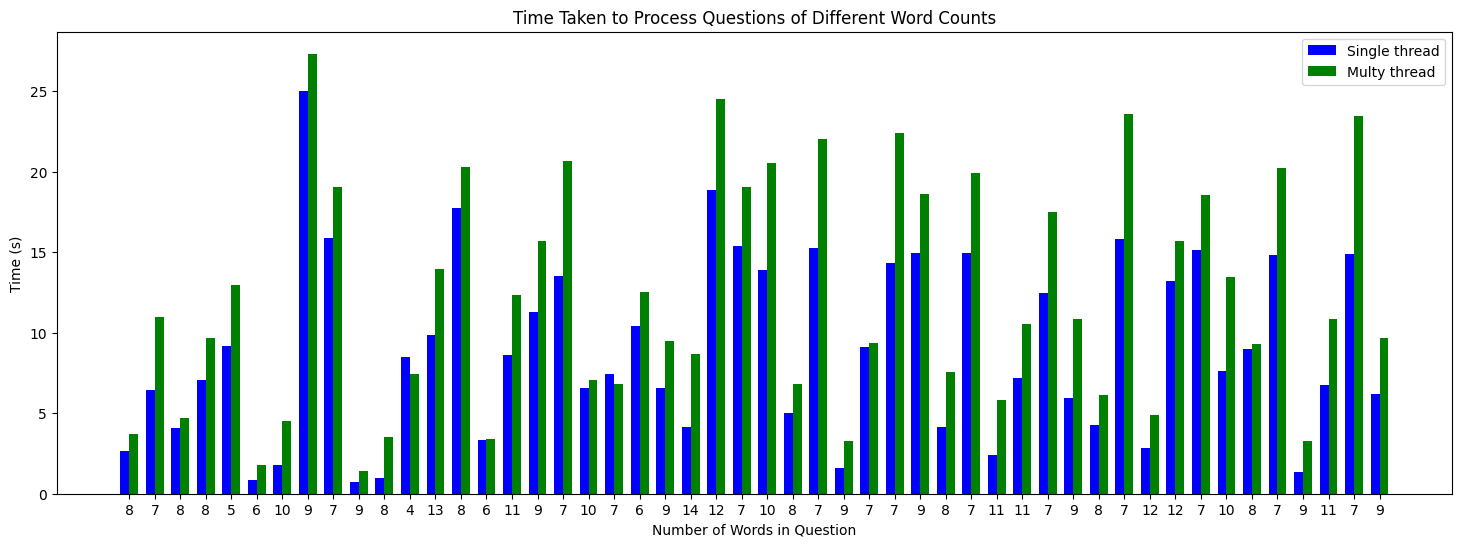

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have two lists of results, result1 and result2, and question_indices as before
result1 = ans_no_thread
result2 = ans_with_thread

# Create a figure and axis with a wider size
fig, ax = plt.subplots(figsize=(18, 6))

# Define bar width and indices for the two sets of results
bar_width = 0.35
indices = np.arange(len(questions_list))
question_lengths = [len(q.split()) for q in questions_list]  # Split question and count words

# Create grouped bar plot
bar1 = ax.bar(indices - bar_width/2, result1, bar_width, label='Single thread', color='b')
bar2 = ax.bar(indices + bar_width/2, result2, bar_width, label='Multy thread', color='g')

# Add labels, title, and legend
ax.set_xlabel('Number of Words in Question')
ax.set_ylabel('Time (s)')
ax.set_title('Time Taken to Process Questions of Different Word Counts')

# Set x-axis ticks and labels
ax.set_xticks(indices)
ax.set_xticklabels(question_lengths)

ax.legend()

# Show plot
plt.show()


In [53]:
# Assuming ans_no_thread and ans_with_thread are the two lists of values
def avg_percentage_difference(list1, list2):
    differences = [(a - b) / ((a + b) / 2) * 100 for a, b in zip(list1, list2)]
    return sum(differences) / len(differences)

avg_diff = avg_percentage_difference(ans_no_thread, ans_with_thread)
print(f"Average Percentage Difference: {avg_diff:.2f}%")

Average Percentage Difference: -37.12%
